# BootstrapNAS + DyNAS-T Example

## Setup

In [1]:
from pathlib import Path
import sys

DYNAST_PATH = "/store/code/opensource/DyNAS-T"
NNCF_PATH = "/store/code/opensource/jpablomch_nncf_bootstrapnas"
HAAML_PATH = Path("/store/code/bootstrapnas/Hardware-Aware-Automated-Machine-Learning")

config_path = HAAML_PATH / "models/supernets/cifar10/resnet50/config.json"
supernet_path = HAAML_PATH / "models/supernets/cifar10/resnet50/elasticity.pth"
supernet_weights = HAAML_PATH / "models/supernets/cifar10/resnet50/supernet_weights.pth"
fp32_pth_url = HAAML_PATH / "models/pretrained/resnet50.pt"

if DYNAST_PATH not in sys.path:
    sys.path.insert(0, DYNAST_PATH)

if NNCF_PATH not in sys.path:
    sys.path.insert(0, NNCF_PATH)

import json
import logging
import random

import torch
from addict import Dict
from examples.torch.common.models.classification.resnet_cifar10 import resnet50_cifar10
from nncf import set_log_level
from nncf.experimental.torch.nas.bootstrapNAS.search.supernet import SuperNetwork

from dynast.dynast_manager import DyNAS
from dynast.utils import log, set_logger

set_log_level(logging.ERROR)
set_logger(logging.INFO)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch


[04-03 21:32:12 MainProcess #2149] INFO  text_to_speech.py:34 - Please install tensorboardX: pip install tensorboardX


```
If any dependencies are missing, please uncomment the code block below and then run it. After the installation is done please comment it back and restart the kernel.
```

In [2]:
# ! pip install -e $NNCF_PATH
# ! pip install -r $DYNAST_PATH/requirements.txt
# ! pip install addict tensorboard efficientnet_pytorch shapely

# TODO(macsz) ISSUE - NNCF uses old version of pymoo

## Configure BootstrapNAS

In [3]:
with open(config_path) as f:
    nncf_config = Dict(json.load(f))
nncf_config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # TODO(macsz) Update this.
log.info(f"Using device: {nncf_config.device}")
nncf_config.log_dir = "runs"
nncf_config.checkpoint_save_dir = nncf_config.log_dir
nncf_config.batch_size = 256
nncf_config.dataset = "cifar10"
nncf_config.name = "dynast_bnas_external"

[04-03 21:32:13 MainProcess #2149] INFO  2226256918.py:4 - Using device: cuda:0


In [5]:
log.info(f"Loading base model {fp32_pth_url}...")
model = resnet50_cifar10()
state_dict = torch.load(fp32_pth_url)
model.load_state_dict(state_dict)
model.to(nncf_config.device)

log.info("Bootstrapping model...")
bootstrapNAS = SuperNetwork.from_checkpoint(
    model=model,
    nncf_config=nncf_config,
    supernet_path=supernet_path,
    supernet_weights=supernet_weights,
)

[04-03 21:32:31 MainProcess #2149] INFO  4068363791.py:1 - Loading base model /store/code/bootstrapnas/Hardware-Aware-Automated-Machine-Learning/models/pretrained/resnet50.pt...
[04-03 21:32:33 MainProcess #2149] INFO  4068363791.py:7 - Bootstrapping model...


## DyNAS-T Search Example

In [6]:
dynas = DyNAS(
    supernet='bootstrapnas_image_classification',
    results_path='bootstrapnas_resnet50_cifar10_linas.csv',
    search_tactic='linas',
    num_evals=250,
    population=50,
    optimization_metrics=['accuracy_top1', 'macs'],
    measurements=['accuracy_top1', 'macs'],
    batch_size=nncf_config.batch_size,
    dataset_path='/tmp/cifar10',
    bootstrapnas=bootstrapNAS,  # This is the only new param that has to be passed
    device=nncf_config.device,
    verbose=False,
)
dynas.search()

[04-03 21:32:36 MainProcess #2149] INFO  dynast_manager.py:44 - ========================================
[04-03 21:32:36 MainProcess #2149] INFO  dynast_manager.py:45 - Starting Dynamic NAS Toolkit (DyNAS-T)
[04-03 21:32:36 MainProcess #2149] INFO  dynast_manager.py:46 - ========================================
[04-03 21:32:36 MainProcess #2149] INFO  dynast_manager.py:72 - ----------------------------------------
[04-03 21:32:36 MainProcess #2149] INFO  dynast_manager.py:73 - DyNAS Parameter Inputs:
[04-03 21:32:36 MainProcess #2149] INFO  dynast_manager.py:75 - supernet: bootstrapnas_image_classification
[04-03 21:32:36 MainProcess #2149] INFO  dynast_manager.py:75 - results_path: bootstrapnas_resnet50_cifar10_random_test.csv
[04-03 21:32:36 MainProcess #2149] INFO  dynast_manager.py:75 - search_tactic: random
[04-03 21:32:36 MainProcess #2149] INFO  dynast_manager.py:75 - num_evals: 1
[04-03 21:32:36 MainProcess #2149] INFO  dynast_manager.py:75 - population: 1
[04-03 21:32:36 MainP

Files already downloaded and verified


[04-03 21:32:37 MainProcess #2149] INFO  __init__.py:80 - > Finished validation_dataloader in 0.5966 s
[04-03 21:32:37 MainProcess #2149] INFO  __init__.py:75 - > Calling validate_classification
[04-03 21:32:40 MainProcess #2149] INFO  __init__.py:80 - > Finished validate_classification in 2.4787 s
[04-03 21:32:40 MainProcess #2149] INFO  __init__.py:75 - > Calling get_macs
[04-03 21:32:41 MainProcess #2149] INFO  __init__.py:80 - > Finished get_macs in 0.9501 s


[{'width_0': [256],
  'width_1': [512],
  'width_2': [608],
  'width_3': [1632],
  'width_4': [64],
  'width_5': [64],
  'width_6': [32],
  'width_7': [64],
  'width_8': [32],
  'width_9': [32],
  'width_10': [32],
  'width_11': [128],
  'width_12': [64],
  'width_13': [128],
  'width_14': [128],
  'width_15': [128],
  'width_16': [96],
  'width_17': [96],
  'width_18': [128],
  'width_19': [200],
  'width_20': [128],
  'width_21': [200],
  'width_22': [128],
  'width_23': [152],
  'width_24': [256],
  'width_25': [200],
  'width_26': [128],
  'width_27': [152],
  'width_28': [152],
  'width_29': [200],
  'width_30': [200],
  'width_31': [304],
  'width_32': [512],
  'width_33': [512],
  'width_34': [256],
  'width_35': [512],
  'width_36': [304],
  'depth': ['[0, 1, 2, 4]']}]

## Visualize results

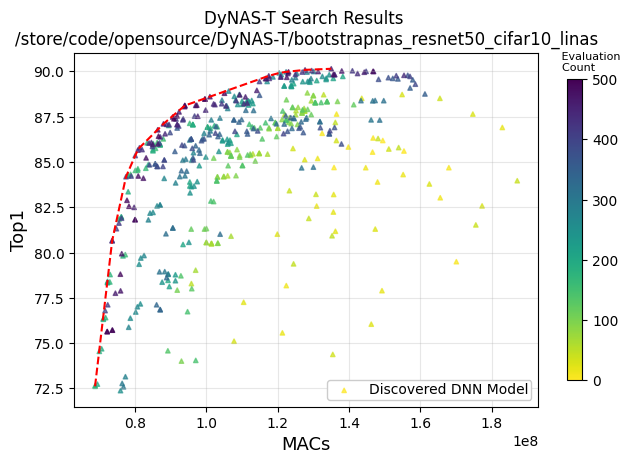

In [16]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import pandas as pd

from dynast.analytics.visualize import frontier_builder


def plot_search_progression(
    results_path: str,
    evals_limit: int = None,
) -> None:
    df = pd.read_csv(results_path)

    if evals_limit:
        df = df[:evals_limit]

    df.columns = ['config', 'date', 'params', 'latency', 'macs', 'accuracy_top1']

    fig, ax = plt.subplots(figsize=(7, 5))

    cm = plt.cm.get_cmap('viridis_r')
    count = [x for x in range(len(df))]

    ax.scatter(
        df['macs'].values,
        df['accuracy_top1'].values,
        marker='^',
        alpha=0.7,
        c=count,
        cmap=cm,
        label='Discovered DNN Model',
        s=10,
    )

    ax.set_title('DyNAS-T Search Results \n{}'.format(results_path.split('.')[0]))
    ax.set_xlabel('MACs', fontsize=13)
    ax.set_ylabel('Top1', fontsize=13)
    ax.legend(fancybox=True, fontsize=10, framealpha=1, borderpad=0.2, loc='lower right')
    ax.grid(True, alpha=0.3)

    df_conc_front = frontier_builder(df, optimization_metrics=['macs', 'accuracy_top1'])
    ax.plot(
        df_conc_front['macs'],
        df_conc_front['accuracy_top1'],
        color='red',
        linestyle='--',
        label='DyNAS-T Pareto front',
    )

    # Eval Count bar
    norm = plt.Normalize(0, len(df))
    sm = ScalarMappable(norm=norm, cmap=cm)
    cbar = fig.colorbar(sm, ax=ax, shrink=0.85)
    cbar.ax.set_title("         Evaluation\n  Count", fontsize=8)

    fig.tight_layout(pad=2)
    plt.show()


plot_search_progression(
    results_path='/store/code/opensource/DyNAS-T/bootstrapnas_resnet50_cifar10_linas.csv',
)
